In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [17]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [18]:
train_data.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [19]:
test_data.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [20]:
# 결측치 처리
train_data['강수량(mm)'].fillna(0, inplace=True)
train_data['풍속(m/s)'].fillna(train_data['풍속(m/s)'].mean(), inplace=True)
train_data['습도(%)'].fillna(train_data['습도(%)'].mean(), inplace=True)
train_data['일조(hr)'].fillna(0, inplace=True)
train_data['일사(MJ/m2)'].fillna(0, inplace=True)
test_data['강수량(mm)'].fillna(0, inplace=True)
test_data['일조(hr)'] = 0
test_data['일사(MJ/m2)'] = 0

In [21]:
train_data.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.0,0.0,1047.36
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.0,0.0,974.88
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.0,0.0,953.76
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.0,0.0,986.40


In [22]:
# 날짜 및 시간 특성 파생
train_data['일시'] = pd.to_datetime(train_data['일시'], format='%Y%m%d %H')
test_data['일시'] = pd.to_datetime(test_data['일시'], format='%Y%m%d %H')
train_data['연'] = train_data['일시'].dt.year
train_data['월'] = train_data['일시'].dt.month
train_data['일'] = train_data['일시'].dt.day
train_data['시간'] = train_data['일시'].dt.hour
test_data['연'] = test_data['일시'].dt.year
test_data['월'] = test_data['일시'].dt.month
test_data['일'] = test_data['일시'].dt.day
test_data['시간'] = test_data['일시'].dt.hour

In [23]:
train_data.drop(columns=['num_date_time', '일시'], inplace=True)
test_data.drop(columns=['num_date_time', '일시'], inplace=True)

In [24]:
train_data.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연,월,일,시간
0,1,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,2022,6,1,0
1,1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,2022,6,1,1
2,1,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2022,6,1,2
3,1,16.7,0.0,1.4,48.0,0.0,0.0,953.76,2022,6,1,3
4,1,18.4,0.0,2.8,43.0,0.0,0.0,986.40,2022,6,1,4


In [25]:
X_train = train_data.drop(columns = ['전력소비량(kWh)'])
y_train = train_data['전력소비량(kWh)']

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_data)

In [27]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [28]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [5000],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
}

In [29]:
'''
xgb_model = XGBRegressor(objective = 'reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train_split, y_train_split, eval_set = [(X_val_split, y_val_split)], early_stopping_rounds=10, verbose=True)

print(f"Best parameters: {grid_search.best_params_}")

y_val_pred_best = grid_search.best_estimator_.predict(X_val_split)
val_rmse_best = np.sqrt(mean_squared_error(y_val_split, y_val_pred_best))

print(f"Validation RMSE: {val_rmse_best}")

# test 데이터에 대한 예측
y_test_pred_best = grid_search.best_estimator_.predict(X_test_scaled)
test_predictions_best = pd.DataFrame({'전력소비량(kWh)': y_test_pred_best})

test_predictions_best.head()
test_predictions_best.to_csv('./output/test_predictions_best.csv', index=False)
'''

'\nxgb_model = XGBRegressor(objective = \'reg:squarederror\', random_state=42)\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring=\'neg_mean_squared_error\')\ngrid_search.fit(X_train_split, y_train_split, eval_set = [(X_val_split, y_val_split)], early_stopping_rounds=10, verbose=True)\n\nprint(f"Best parameters: {grid_search.best_params_}")\n\ny_val_pred_best = grid_search.best_estimator_.predict(X_val_split)\nval_rmse_best = np.sqrt(mean_squared_error(y_val_split, y_val_pred_best))\n\nprint(f"Validation RMSE: {val_rmse_best}")\n\n# test 데이터에 대한 예측\ny_test_pred_best = grid_search.best_estimator_.predict(X_test_scaled)\ntest_predictions_best = pd.DataFrame({\'전력소비량(kWh)\': y_test_pred_best})\n\ntest_predictions_best.head()\ntest_predictions_best.to_csv(\'./output/test_predictions_best.csv\', index=False)\n'

In [30]:
xgb_model = XGBRegressor(
    objective = 'reg:squarederror',
    learning_rate = 0.01,
    max_depth = 7,
    n_estimators = 5000,
    subsample = 0.7,
    colsample_bytree = 0.7,
    random_state=42
).fit(X_train_split, y_train_split, eval_set = [(X_val_split, y_val_split)], early_stopping_rounds=10, verbose=True)

[0]	validation_0-rmse:3426.88959
[1]	validation_0-rmse:3394.99395
[2]	validation_0-rmse:3363.27609
[3]	validation_0-rmse:3345.42546
[4]	validation_0-rmse:3314.37446


d:\Anaconda3\envs\jupyter\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:3283.72863
[6]	validation_0-rmse:3253.25382
[7]	validation_0-rmse:3223.28591
[8]	validation_0-rmse:3206.18200
[9]	validation_0-rmse:3176.85535
[10]	validation_0-rmse:3147.46446
[11]	validation_0-rmse:3131.01550
[12]	validation_0-rmse:3114.81340
[13]	validation_0-rmse:3098.93490
[14]	validation_0-rmse:3083.19087
[15]	validation_0-rmse:3054.78957
[16]	validation_0-rmse:3026.88487
[17]	validation_0-rmse:3011.63600
[18]	validation_0-rmse:2984.15150
[19]	validation_0-rmse:2956.80534
[20]	validation_0-rmse:2929.73864
[21]	validation_0-rmse:2915.17601
[22]	validation_0-rmse:2888.61402
[23]	validation_0-rmse:2862.24762
[24]	validation_0-rmse:2836.13519
[25]	validation_0-rmse:2810.38240
[26]	validation_0-rmse:2784.91189
[27]	validation_0-rmse:2771.66861
[28]	validation_0-rmse:2746.52263
[29]	validation_0-rmse:2721.73847
[30]	validation_0-rmse:2708.61958
[31]	validation_0-rmse:2684.19229
[32]	validation_0-rmse:2660.05963
[33]	validation_0-rmse:2636.20585
[34]	validation_0-r

In [34]:
predict = pd.DataFrame({'전력소비량(kWh)': xgb_model.predict(X_test_scaled)})
predict

,전력소비량(kWh)
0,1927.953247
1,1874.150146
2,1791.704834
3,1698.058716
4,1685.913452
...,...
16795,1076.131958
16796,1020.192322
16797,924.039490
16798,680.541138


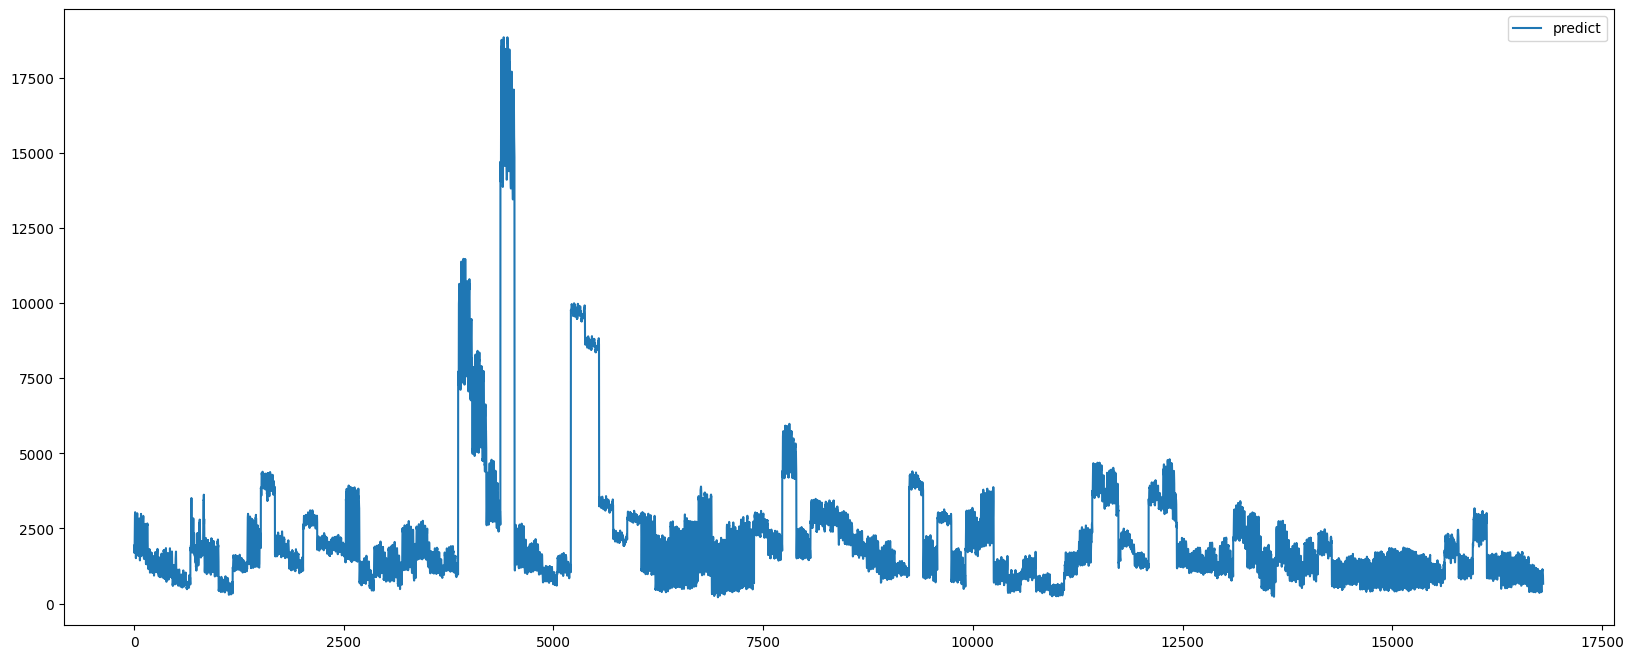

In [46]:
plt.figure(figsize=(20, 8))
plt.plot(predict, label='predict')
plt.legend()

In [49]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
print(len(sample_submission))
sample_submission

16800


,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [50]:
sample_submission['answer'] = predict
sample_submission

,num_date_time,answer
0,1_20220825 00,1927.953247
1,1_20220825 01,1874.150146
2,1_20220825 02,1791.704834
3,1_20220825 03,1698.058716
4,1_20220825 04,1685.913452
...,...,...
16795,100_20220831 19,1076.131958
16796,100_20220831 20,1020.192322
16797,100_20220831 21,924.039490
16798,100_20220831 22,680.541138


In [51]:
sample_submission.to_csv('./output/sample_submission.csv', index=False)